In [1]:
import bisect
import pickle
from collections import Counter

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Charge les référentiels
cf `referentiels.py`

In [2]:
ROME_df = pd.read_csv('../referentiels/referentiel_ROME/20150921_arboprincipale28427_ROME.csv', index_col=0, sep='|', dtype=str)
OGR_df = pd.read_csv('../referentiels/referentiel_OGR/20150921_arboprincipale28427_OGR.csv', sep='|', dtype=str).set_index('OGR')
NAF_df = pd.read_csv('../referentiels/referentiel_NAF/naf2008_liste_n5_nouveau_header.csv', sep='|', encoding="utf-8").set_index(['NAF'])

In [3]:
tranches_effectif = ['00', '01', '02', '03', '11', '12', '21', '22', '31', '32', '41', '42', '51', '52', '53', 'NN']
seuils_tranches_effectif = [0, 1, 3, 6, 10, 20, 50, 100, 200, 250, 500, 1000, 2000, 5000, 10000]

In [4]:
def trouve_tranche_effectif(effectif):
    index = bisect.bisect(seuils_tranches_effectif, effectif) - 1
    return index, tranches_effectif[index]

# Charge les offres

In [7]:
filename = '../LBB_EOF_OFFRES_20160307_20170407_20170407_191410_clean.csv'

In [8]:
df = pd.read_csv(filename, sep='|', dtype=str, keep_default_na=False)

In [9]:
liste_nb_postes = [int(nb_postes) for nb_postes in df.dn_nbrpostesoffertscreation]

In [10]:
len(df), sum(liste_nb_postes)

(7023100, 8568949)

In [11]:
comptage_type_contrat = Counter(df.dc_typecontrat_id)
contrat_labels = comptage_type_contrat.keys()
contrat_comptes = [comptage_type_contrat[t] for t in contrat_labels]
n_type_contrat = len(contrat_labels)

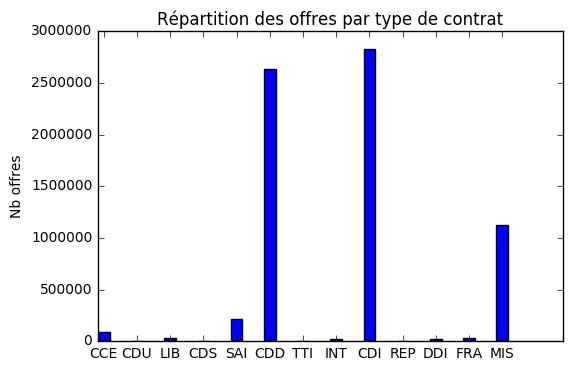

In [12]:
ind = np.arange(n_type_contrat)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, contrat_comptes, width)

ax.set_ylabel('Nb offres')
ax.set_title('Répartition des offres par type de contrat')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(contrat_labels)


In [13]:
comptage_unite_duree = Counter(df.dc_unitedureecontrat)

In [14]:
comptage_unite_duree

Counter({'JO': 550339, 'MO': 3480435, 'null': 2992326})

In [15]:
def calcul_duree(row):
    if row['dc_unitedureecontrat'] == 'null':
        assert row['dc_typecontrat_id'] != 'CDD', row
        assert row['dc_duree_contrat_id'] == '00', row
        return 10*365
    else:
        # assert row['dc_typecontrat_id'] != 'CDI', row # CDI de 36 mois à l'index 271860
        if row['dc_unitedureecontrat'] == 'JO':
            return int(row['dc_duree_contrat_id'])
        elif row['dc_unitedureecontrat'] == 'MO':
            return int(row['dc_duree_contrat_id'])*30
        else:
            print(row)
            raise ValueError()

In [16]:
df['duree_jours'] = df.apply(calcul_duree, axis=1)

In [17]:
comptage_duree = Counter(df.duree_jours)

In [18]:
duree_max = max(comptage_duree.keys())
duree_max

3650

In [19]:
histo = [comptage_duree[i] for i in range(duree_max + 1)]
sum(histo), sum(histo[30:])

(7023100, 6569294)

In [20]:
sum(histo[:370])/sum(histo)

0.5423963776679813

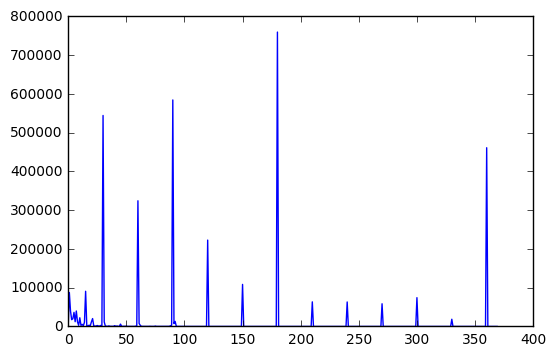

In [21]:
plt.plot(histo[:370])

# Array : OGR x NAF

In [22]:
def ponderation_duree(duree_jours):
    return 1 if duree_jours >= 30 else 0

In [23]:
n_NAF = len(NAF_df)
n_OGR = len(OGR_df)


In [24]:
array = np.zeros((n_NAF, n_OGR))

set_OGR = set(OGR_df.index)
set_NAF = set(NAF_df.index)

for i, row in df.iterrows():
    (dn_nbrpostesoffertscreation, dc_rome_id, dc_appelationrome_id,
     dc_naturecontrat_id, dc_typecontrat_id, dc_unitedureecontrat,
     dc_duree_contrat_id, dc_naf2, duree_jours) = row
    
    dc_appelationrome_id = dc_appelationrome_id[-5:]
    
    if (dc_naf2 in set_NAF) and (dc_appelationrome_id in set_OGR):
        NAF_index = NAF_df.index.get_loc(dc_naf2)
        OGR_index = OGR_df.index.get_loc(dc_appelationrome_id)
            
        poids = ponderation_duree(duree_jours) * int(dn_nbrpostesoffertscreation)
        
        array[NAF_index, OGR_index] += poids

    if i % 100000 == 0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000


In [26]:
with open('../array_offres_OGR.pickle', 'wb') as f:
    pickle.dump(array, f)

# Array : ROME x NAF

In [27]:
def ponderation_duree(duree_jours):
    return 1 if duree_jours >= 30 else 0
        

In [28]:
df.columns

Index(['dn_nbrpostesoffertscreation', 'dc_rome_id', 'dc_appelationrome_id',
       'dc_naturecontrat_id', 'dc_typecontrat_id', 'dc_unitedureecontrat',
       'dc_duree_contrat_id', 'dc_naf2', 'duree_jours'],
      dtype='object')

In [29]:
n_NAF = len(NAF_df)
n_ROME = len(ROME_df)


In [30]:
array = np.zeros((n_NAF, n_ROME))


for i, row in df.iterrows():
    (dn_nbrpostesoffertscreation, dc_rome_id, dc_appelationrome_id,
     dc_naturecontrat_id, dc_typecontrat_id, dc_unitedureecontrat,
     dc_duree_contrat_id, dc_naf2, duree_jours) = row
    
    if (dc_naf2 in NAF_df.index) and (dc_rome_id in ROME_df.index):
        NAF_index = NAF_df.index.get_loc(dc_naf2)
        ROME_index = ROME_df.index.get_loc(dc_rome_id)
            
        poids = ponderation_duree(duree_jours) * int(dn_nbrpostesoffertscreation)
        
        array[NAF_index, ROME_index] += poids

    if i % 100000 == 0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000


In [31]:
with open('../array_offres.pickle', 'wb') as f:
    pickle.dump(array, f)